## Описание проекта

Компания, предоставляющая услуги такси предоставила данные о заказах такси в аэропортах. Необходимо построить модель, способную предсказать достаточное количество водителей на следующий час.


### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*'.

# 1. Подготовка

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib
import matplotlib.pyplot as plt
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
pd.options.mode.chained_assignment = None

In [2]:
taxi = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])

In [3]:
taxi.sort_index(inplace=True)
taxi = taxi.resample('1H').sum()

In [4]:
taxi.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71


In [5]:
taxi.tail(3)

,num_orders
datetime,
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


In [6]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


### Вывод

Загрузили данные, которые представляют два столбца - дату (с точностью до 10 мин) и количество заказов. Произвели ресемплинг до 1 часа. Дата варьируется от 2018-03 до 2018-08 включительно. 

# 2. Анализ

Проведем первичный анализ данных с помощью скользящего среднего и изучим сезонность.

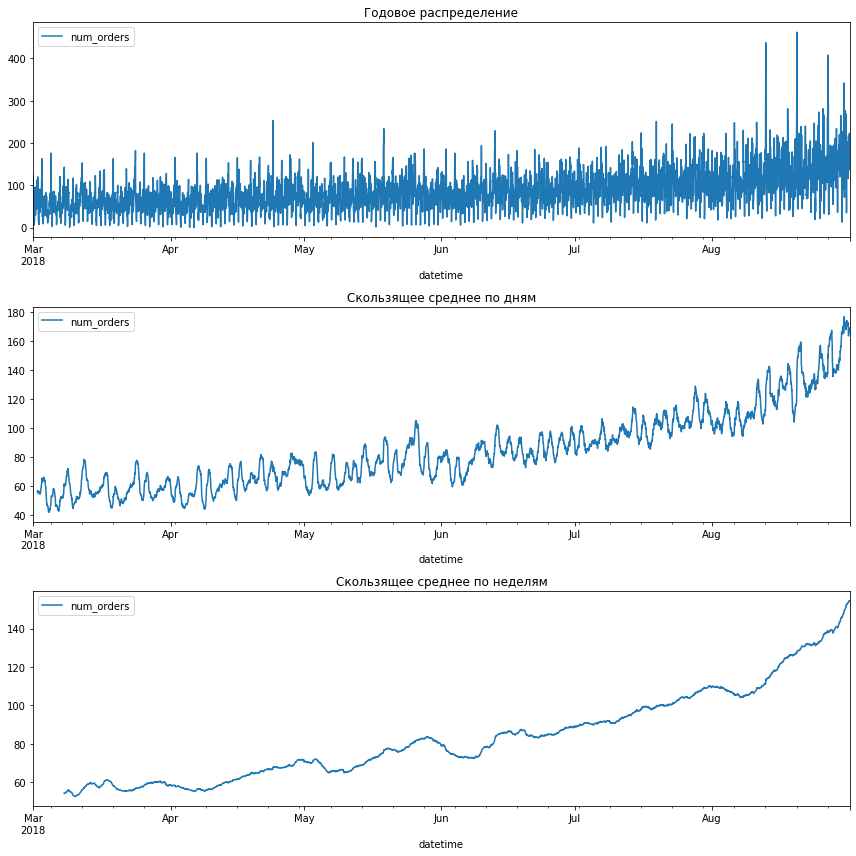

In [7]:
plt.figure(figsize=(12, 12))
plt.subplot(311)
taxi.plot(ax=plt.gca())
plt.title('Годовое распределение')
plt.subplot(312)
taxi.rolling(24).mean().plot(ax=plt.gca())
plt.title('Скользящее среднее по дням')
plt.subplot(313)
taxi.rolling(168).mean().plot(ax=plt.gca())
plt.title('Скользящее среднее по неделям')
plt.tight_layout()

In [8]:
decomposed = seasonal_decompose(taxi)

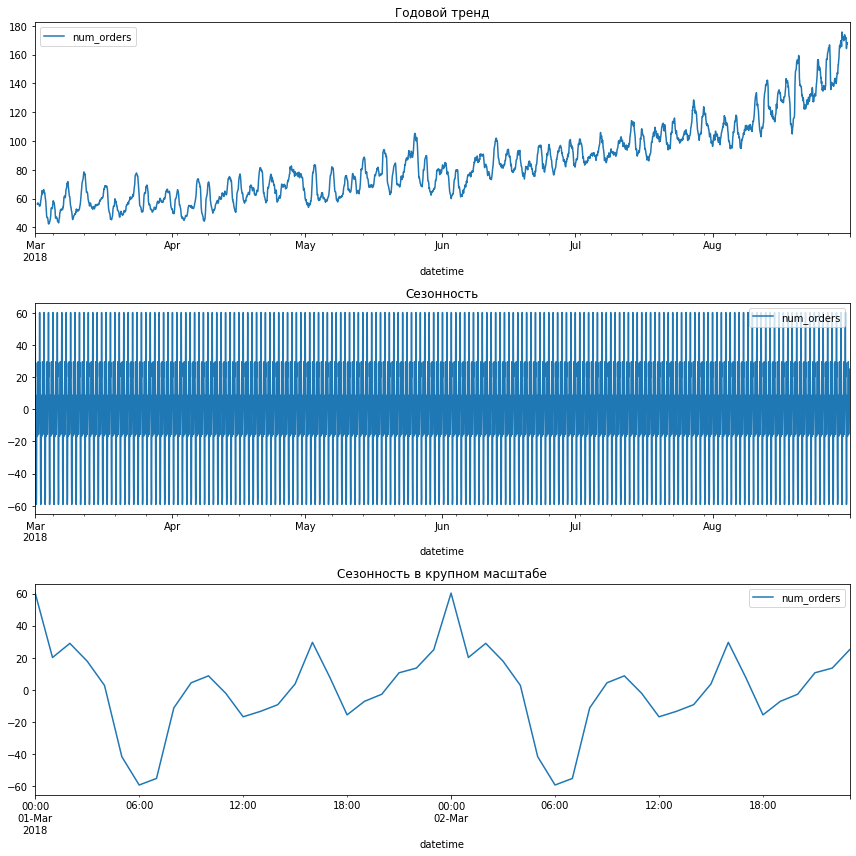

In [9]:
plt.figure(figsize=(12, 12))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Годовой тренд')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')

plt.subplot(313)
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(ax=plt.gca()) 
plt.title('Сезонность в крупном масштабе')
plt.tight_layout()

### Вывод

С помощью скользящего среднего видно, что общий спрос на такси в течении года растет. Возможные причины:
- люди стали чаще пользоваться услугами такси
- зимой и весной реже пользуются такси, спрос растет летом-осенью Однако для этого анализа требуются данные за другие года.

С помощью анализа сезонности можно заметить, что существует три максимально загруженных временных промежутка: с 8 до 10, с 16 до 17 и с 23 до 24. Максимальный спад происходит в районе 6 утра.

# 3. Обучение

Обучим несколько моделей на тренировочной выборке, которая составляет 90% от всего датасета.

In [10]:
def make_features(data, max_lag, rolling_mean_size):
    #data['year'] = data.index.year - данные за один год, поэтому не важны
    #data['month'] = data.index.month - данные за один год, поэтому нет смысла разбивать на месяцы
    #data['day'] = data.index.day - данные отсортированы по времени, поэтому нет смысла "дублировть" индекс
    data['dayofweek'] = data.index.dayofweek # в выходные и будние дни спрос может быть разным - оставим
    data['hour'] = data.index.hour # судя по графикам из предыдущего пункта, есть зависимость спроса от времени - оставляем
    
    #Временной lag (предыдущие значения временного ряда подскажут, будет ли целевой признак расти или уменьшаться):
    for lag in range(1,max_lag+1):
        data['lag_'+str(lag)] = data['num_orders'].shift(lag)

    #Скользящее среднее (как признак задаёт общий тренд временного ряда):
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [11]:
mae_lr = []
mae_rfr = []
mae_cbr = []

In [12]:
for max_lag in range(7,10): #lag от 7 до 9 чтобы охватить дневной тренд целиком
    print("\nmax_lag:", max_lag)
    for rolling_mean_size in range (7,10): #rolling от 7 до 9 чтобы охватить дневной тренд целиком 
        print("rolling_mean_size:", rolling_mean_size)
        #date to features
        make_features(taxi, max_lag, rolling_mean_size)
        taxi = taxi.dropna()
        
        target = taxi['num_orders']
        features = taxi.drop('num_orders', axis=1)
        features_train, features_valid, target_train, target_valid = train_test_split(
            features, target, shuffle=False, test_size=0.1)
        
        #LinearRegression:
        model_lr = LinearRegression()
        model_lr.fit(features_train, target_train)
        predict_lr = model_lr.predict(features_valid)
        print("MAE LR:", mean_absolute_error(predict_lr, target_valid))
        mae_lr.append(mean_absolute_error(predict_lr, target_valid))
        
        #RandomForest:
        model_rfr = RandomForestRegressor(random_state=12345, max_depth=rolling_mean_size*5, n_estimators=rolling_mean_size*5)
        model_rfr.fit(features_train, target_train)
        predict_rfr = model_rfr.predict(features_valid)
        print("MAE RFR:", mean_absolute_error(predict_rfr, target_valid))
        mae_rfr.append(mean_absolute_error(predict_rfr, target_valid))
        
        #CatBoost:
        model_cbr = CatBoostRegressor(loss_function='RMSE', iterations=rolling_mean_size*30, thread_count=rolling_mean_size*3)
        model_cbr.fit(features_train, target_train, verbose=False)
        predict_cbr = model_cbr.predict(features_valid)
        print("MAE CBR:", mean_absolute_error(predict_cbr, target_valid))
        mae_cbr.append(mean_absolute_error(predict_cbr, target_valid))
        
        #в последних двух моделях параметры количество деревьев и их глубинна вычисляются
        #в зависимости от лага и роллинга для удобства перебора параметров


max_lag: 7
rolling_mean_size: 7
MAE LR: 41.76520112082412
MAE RFR: 35.436669906057666
MAE CBR: 37.15968597903711
rolling_mean_size: 8
MAE LR: 41.511640005708315
MAE RFR: 34.926814058956914
MAE CBR: 37.221196083630964
rolling_mean_size: 9
MAE LR: 41.35275383667744
MAE RFR: 34.60484848484849
MAE CBR: 36.003198002741506

max_lag: 8
rolling_mean_size: 7
MAE LR: 41.45029613911867
MAE RFR: 35.71012040351448
MAE CBR: 36.72628790870278
rolling_mean_size: 8
MAE LR: 41.49613049028812
MAE RFR: 34.684018264840184
MAE CBR: 36.48431672188492
rolling_mean_size: 9
MAE LR: 41.818650528394194
MAE RFR: 33.516094584286805
MAE CBR: 35.59349960745039

max_lag: 9
rolling_mean_size: 7
MAE LR: 41.84145115590977
MAE RFR: 34.78610747051114
MAE CBR: 37.064341432104975
rolling_mean_size: 8
MAE LR: 41.95778457249987
MAE RFR: 35.811436781609196
MAE CBR: 37.00715512661172
rolling_mean_size: 9
MAE LR: 41.86781975918138
MAE RFR: 34.21449052739376
MAE CBR: 36.28367862835952


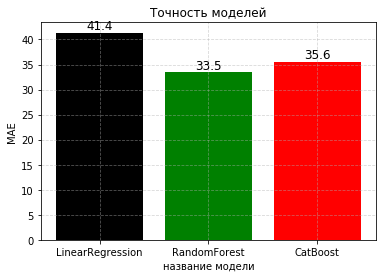

In [13]:
#График
models = ["LinearRegression", "RandomForest", "CatBoost"]
mae_all = [min(mae_lr), min(mae_rfr), min(mae_cbr)]
plt.figure(figsize=(6, 4))
plt.bar(models, mae_all, color='kgr')

plt.grid(linestyle='--', alpha=0.5)
plt.title('Точность моделей')
plt.xlabel("название модели")
plt.ylabel("MAE")
#Подписи значений
mae_all_round = [round(i,1) for i in mae_all]
for i, val in enumerate(mae_all_round):
    plt.text(i, val, float(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':100, 'size':12})

plt.show()

### Вывод

ТОП моделей выглядит следующим образом:<br>
1) Случайный лес (lag  8, rolling 9, деревьев и глубина 45): MAE = 33.5.<br>
2) CatBoost (lag 8, rolling 9, итераций 270): MAE = 35.6.<br>
3) Линейная ргерессия (lag 7, rolling 9): MAE = 41.4.<br>

# 4. Тестирование

Проверим лучшие модели на тестовой выборке.

In [14]:
make_features(taxi, 9, 8)
taxi = taxi.dropna()

target = taxi['num_orders']
features = taxi.drop('num_orders', axis=1)
features_train, features_valid, target_train, target_valid = train_test_split(
            features, target, shuffle=False, test_size=0.1)

In [15]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)
predict_lr = model_lr.predict(features_valid)
print("MSE LR:", mean_squared_error(predict_lr, target_valid))
print("RMSE LR:", sqrt(mean_squared_error(target_valid, predict_lr)))

MSE LR: 2946.1646191867935
RMSE LR: 54.278583430177996


In [16]:
model_rfr = RandomForestRegressor(random_state=12345, max_depth=20, n_estimators=20)
model_rfr.fit(features_train, target_train)
predict_rfr = model_rfr.predict(features_valid)
print("MSE RFR:", mean_squared_error(predict_rfr, target_valid))
print("RMSE RFR:", sqrt(mean_squared_error(predict_rfr, target_valid)))

MSE RFR: 2060.248733281572
RMSE RFR: 45.38996291341922


In [17]:
model_cbr = CatBoostRegressor(loss_function='RMSE', iterations=120, thread_count=12)
model_cbr.fit(features_train, target_train, verbose=False)
predict_cbr = model_cbr.predict(features_valid)
print("MSE CBR:", mean_squared_error(predict_cbr, target_valid))
print("RMSE CBR:", sqrt(mean_squared_error(predict_cbr, target_valid)))

MSE CBR: 2989.6526258346257
RMSE CBR: 54.67771598955671


In [18]:
taxi2 = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])
taxi2.sort_index(inplace=True)
taxi2 = taxi2.resample('1H').sum()

In [19]:
orders = taxi2['num_orders']
train_orders, test_orders = train_test_split(orders, shuffle=False, test_size=0.1)

print("Среднее количество заказов в час:", test_orders.mean())

pred_previous = test_orders.shift()
pred_previous.iloc[0] = train_orders.iloc[-1]
print("MAE Pred:", mean_squared_error(test_orders, pred_previous))
print("RMSE Pred:", sqrt(mean_squared_error(test_orders, pred_previous)))

Среднее количество заказов в час: 139.55656108597285
MAE Pred: 3464.085972850679
RMSE Pred: 58.856486242815066


In [20]:
rmse_lr = sqrt(mean_squared_error(predict_lr, target_valid))
rmse_rfr = sqrt(mean_squared_error(predict_rfr, target_valid))
rmse_cbr = sqrt(mean_squared_error(predict_cbr, target_valid))
rmse_pv = sqrt(mean_squared_error(test_orders, pred_previous))

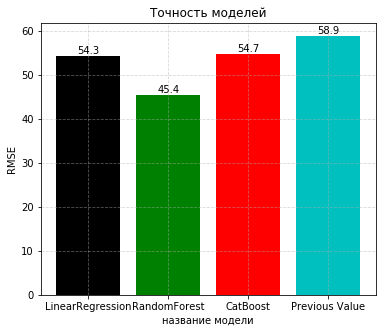

In [21]:
#График
models_final = ["LinearRegression", "RandomForest", "CatBoost", "Previous Value"]
RMSE_all = [rmse_lr, rmse_rfr, rmse_cbr, rmse_pv]
plt.figure(figsize=(6, 5))
plt.bar(models_final, RMSE_all, color='kgrc')

plt.grid(linestyle='--', alpha=0.5)
plt.title('Точность моделей')
plt.xlabel("название модели")
plt.ylabel("RMSE")
#Подписи значений
mae_all_round = [round(i,1) for i in RMSE_all]
for i, val in enumerate(mae_all_round):
    plt.text(i, val, float(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':100, 'size':10})

plt.show()

In [22]:
prediction = target_valid

In [23]:
prediction = pd.DataFrame({'datetime':target_valid.index,'lr':predict_lr, 'rfr':predict_rfr, 'cbr':predict_cbr, 'target':target_valid.values})

In [24]:
prediction.head(3)

,datetime,lr,rfr,cbr,target
0,2018-08-13 22:00:00,131.496483,140.250000,115.762786,104
1,2018-08-13 23:00:00,118.928653,119.033333,107.461915,134
2,2018-08-14 00:00:00,109.611472,196.450000,161.548867,139


Построим график предсказаний и верных значений за сутки.

In [25]:
#Выделим данный за сутки: 
prediction_range = prediction.head(24)

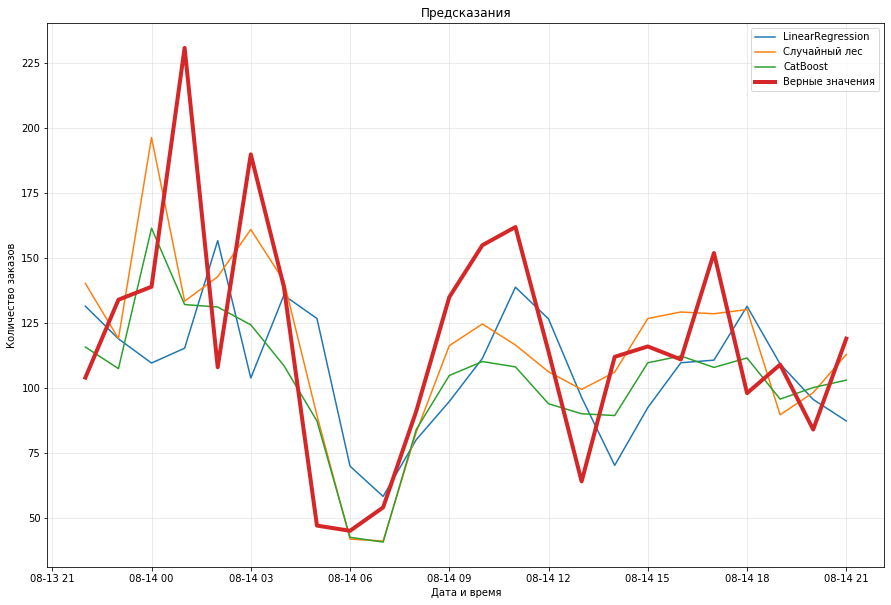

In [28]:
plt.figure(figsize=(15, 10))
plt.plot(prediction_range['datetime'], prediction_range['lr'], label='LinearRegression')
plt.plot(prediction_range['datetime'], prediction_range['rfr'], label='Случайный лес')
plt.plot(prediction_range['datetime'], prediction_range['cbr'], label='CatBoost')
plt.plot(prediction_range['datetime'], prediction_range['target'],linewidth=4.0, label='Верные значения')
plt.title('Предсказания')
plt.xlabel("Дата и время")
plt.ylabel("Количество заказов")
plt.grid(axis='both', alpha=.3)
plt.legend()
plt.show()

### Вывод

Были проанализированы данные и выявлены годовые и суточные зависимости спроса. Обучены несколько моделей предсказания, из которых лучшая модель (Случайный лес) предсказывает спрос на такси с RMSE = 45. RMSE CatBoost'a и Линейной регрессии схожи и равны 54. Все три модели показали себя лучше, нежели предсказание предыдущим шагом (RMSE данного метода больше других и равен 59).
Построили график предсказаний, по которому видно, что модели предсказывают достаточно точно, однако "проседают" в пиковые моменты. Возможно, если сделать ресемплинг меньше часа, то модели обучатся лучше.